In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve


In [31]:
df_cct = pd.read_parquet("/home/onyxia/work/df_cct_final.parquet")

## I. One Hot Encoder

In [32]:
# Pour "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [33]:
# Pour "day_of_week" : 

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["day_of_week"]]).toarray()

features_labels = np.hstack(np.array(enc.get_feature_names_out()))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

## II. Sorting the columns

In [35]:
df_cct = df_cct[['Card', 'Month', 'Day', 'Hours', 'Amount',
       'delta_t_s', 'delta_t_s_card', 'amt/daily_income', 'Retired',
       'daily_amount', 'nb_daily_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt', 'last_3d_amt/nbt', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction', 'day_of_week_Friday',
       'day_of_week_Monday', 'day_of_week_Saturday', 'day_of_week_Sunday',
       'day_of_week_Thursday', 'day_of_week_Tuesday', 'day_of_week_Wednesday','Is Fraud?']]

## Logistic regression on initial dataset

In [50]:
feature_names = df_cct.iloc[:, :25].columns
target = "Is Fraud?"

data_features = df_cct[feature_names]
data_target = df_cct[target]

In [51]:
from sklearn.model_selection import train_test_split
np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(data_features, data_target, 
                                                    train_size = 0.70, test_size = 0.30, random_state = 1)

In [62]:
robust_transform = Pipeline(steps=['rb', RobustScaler()])
preprocessor = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('std', RobustScaler(), ['Card', 'Month', 'Day', 'Hours', 'Amount',
       'delta_t_s', 'delta_t_s_card', 'amt/daily_income',
       'daily_amount', 'nb_daily_declines_card', 'hr_nbt/last_30d_av_hr_nbt', 'last_3d_amt/nbt',])
        ])
lr = Pipeline(steps = [('pr', preprocessor), ('lr', LogisticRegression(class_weight = {1:0.85, 0:0.15}))])

In [63]:
lr.fit(X_train, y_train)

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('pr',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('std', RobustScaler(),
                                                  ['Card', 'Month', 'Day',
                                                   'Hours', 'Amount',
                                                   'delta_t_s',
                                                   'delta_t_s_card',
                                                   'amt/daily_income',
                                                   'daily_amount',
                                                   'nb_daily_declines_card',
                                                   'hr_nbt/last_30d_av_hr_nbt',
                                                   'last_3d_amt/nbt'])])),
                ('lr', LogisticRegression(class_weight={0: 0.15, 1: 0.85}))])

## Confusion Matrix - Model Performance measures

In [64]:
def RunModel(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train.values.ravel())
    pred = model.predict(X_test)
    matrix = confusion_matrix(y_test, pred)
    return matrix, pred

In [65]:
def PrintStats(cmat, y_test, pred):
    tpos = cmat[0][0]
    fneg = cmat[1][1]
    fpos = cmat[0][1]
    tneg = cmat[1][0]

## Classification Report - Model Performance Measures

In [66]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve


In [68]:
cmat, pred = RunModel(lr, X_train, y_train, X_test, y_test)

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


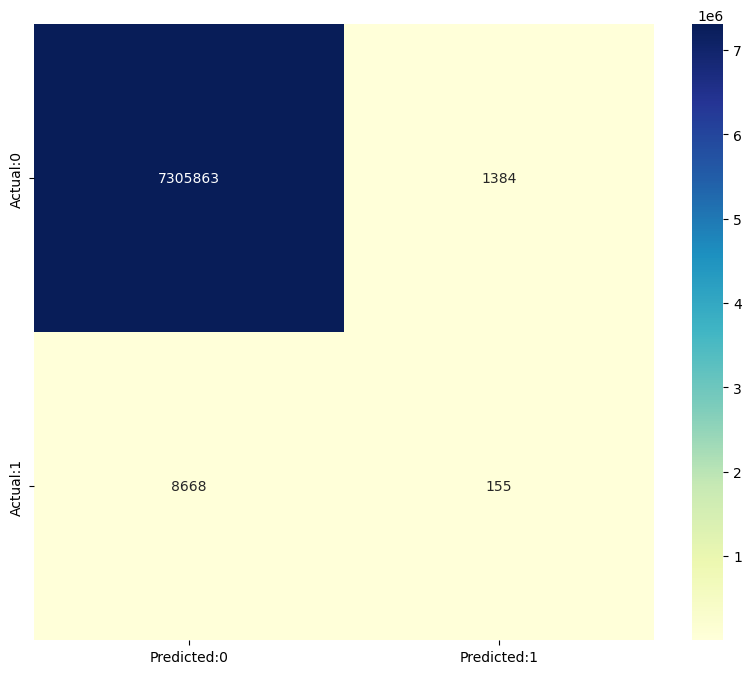

In [69]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (10,8))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

In [70]:
accuracy_score(y_test, pred)

0.9986260382965171

In [71]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   7307247
           1       0.10      0.02      0.03      8823

    accuracy                           1.00   7316070
   macro avg       0.55      0.51      0.51   7316070
weighted avg       1.00      1.00      1.00   7316070



## Applying Undersampling Technique

In [72]:
# The function "len" counts the number of classes = 1 and saves it as an object "fraud_records"
fraud_records = len(df_cct[df_cct["Is Fraud?"] == 1])
# Defines the index for fraud and non-fraud in the lines:
fraud_indices = df_cct[df_cct["Is Fraud?"] == 1].index
not_fraud_indices = df_cct[df_cct["Is Fraud?"] == 0].index
# Randomly collect equal samples of each type:
under_sample_indices = np.random.choice(not_fraud_indices, fraud_records, False)
df_undersampled = df_cct.iloc[np.concatenate([fraud_indices, under_sample_indices]),:]
X_undersampled = df_undersampled.iloc[:,:25]
Y_undersampled = df_undersampled["Is Fraud?"]
X_undersampled_train, X_undersampled_test, Y_undersampled_train, Y_undersampled_test = train_test_split(X_undersampled, Y_undersampled, test_size = 0.30)


In [73]:
lr_undersampled = Pipeline(steps = [('pr', preprocessor), ('lr', LogisticRegression())])

In [74]:
cmat, pred = RunModel(lr_undersampled, X_undersampled_train, Y_undersampled_train, X_undersampled_test, Y_undersampled_test)
PrintStats(cmat, Y_undersampled_test, pred)

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

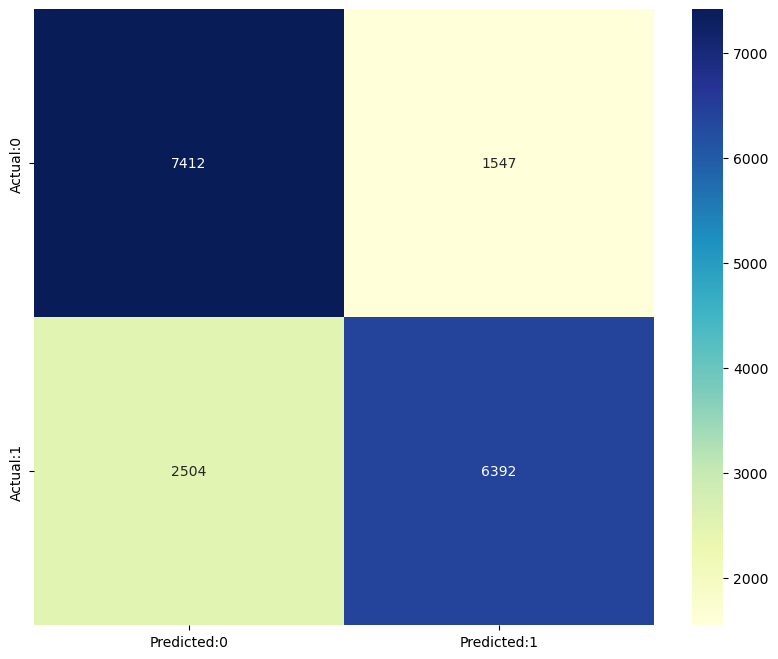

In [43]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Y_undersampled_test, pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (10,8))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu");

In [44]:
from sklearn.metrics import classification_report
print(classification_report(Y_undersampled_test,pred))

              precision    recall  f1-score   support

           0       0.75      0.83      0.79      8959
           1       0.81      0.72      0.76      8896

    accuracy                           0.77     17855
   macro avg       0.78      0.77      0.77     17855
weighted avg       0.78      0.77      0.77     17855



In [ ]:
lr_undersampled = 

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {"C": [1,2,3,4,5,6,7,8,9,10], 
              "penalty": ['l1','l2']} #Parameters
            
grid_search = GridSearchCV(LogisticRegression(), param_grid, scoring="precision") #score
grid_search.fit(y_test, pred)

lr = grid_search.best_estimator_ 
grid_search.best_params_, grid_search.best_score_